# Hypothesis Testing Project on Northwind Database         by _Luigi Fiori_

During this project we'll be gathering information from a real-world database and use our knowledge of statistical analysis and hypothesis testing to generate analytical insights that can be of value to the company.

This is a free and open-source dataset called "Northwind Database", created by Microsoft and containing data from a fictional company.

We start checking the files present in our repo.

In [1]:
ls 

 Volume in drive C is OS
 Volume Serial Number is D816-28B0

 Directory of C:\Users\luigi\FlatironSchool\Module03\Project_Mod_03\dsc-mod-3-project-online-ds-pt-051319

23/09/2019  18:04    <DIR>          .
23/09/2019  18:04    <DIR>          ..
14/09/2019  13:12                29 .gitignore
23/09/2019  14:46    <DIR>          .ipynb_checkpoints
14/09/2019  13:12                93 .learn
14/09/2019  13:12           526,610 adventureworks2008_schema.gif
14/09/2019  13:12             1,849 CONTRIBUTING.md
14/09/2019  13:12         2,930,391 halfway-there.gif
14/09/2019  13:12             1,371 LICENSE.md
14/09/2019  13:12            78,531 module3_project_rubric.pdf
14/09/2019  13:12            96,050 Northwind_ERD.png
14/09/2019  13:12            96,271 Northwind_ERD_updated.png
14/09/2019  13:12           290,816 Northwind_small.sqlite
23/09/2019  15:54    <DIR>          pics_category
23/09/2019  15:54    <DIR>          pics_countries
23/09/2019  16:06    <DIR>          pics_december
23

# Importing needed libraries

In [2]:
import pandas as pd
import sqlite3 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import itertools
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
import warnings
warnings.filterwarnings('ignore')

## Connect to SQL Database

In [3]:
conn = sqlite3.Connection('Northwind_small.sqlite')
cur = conn.cursor()

Querying our database

In [4]:
cur.execute("""SELECT ProductID, ProductName, UnitPrice, Quantity, Discount
               FROM Product
               JOIN OrderDetail
               USING(UnitPrice)
               """)
df = pd.DataFrame(cur.fetchall()) #Take results and create dataframe
df.columns = [i[0] for i in cur.description]
df.head()

,ProductId,ProductName,UnitPrice,Quantity,Discount
0,1,Chai,18.0,2,0.00
1,1,Chai,18.0,3,0.00
2,1,Chai,18.0,4,0.00
3,1,Chai,18.0,4,0.25
4,1,Chai,18.0,5,0.20


# EDA

###### Let's analise the dataframe created to check number of columns, rows and size.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2458 entries, 0 to 2457
Data columns (total 5 columns):
ProductId      2458 non-null int64
ProductName    2458 non-null object
UnitPrice      2458 non-null float64
Quantity       2458 non-null int64
Discount       2458 non-null float64
dtypes: float64(2), int64(2), object(1)
memory usage: 96.1+ KB


Check presence of missing values.

In [6]:
df.isnull().sum()

ProductId      0
ProductName    0
UnitPrice      0
Quantity       0
Discount       0
dtype: int64

We wanna now check if there are outliers present in our data set.

In [7]:
df.describe()

,ProductId,UnitPrice,Quantity,Discount
count,2458.000000,2458.000000,2458.000000,2458.000000
mean,39.437347,23.460460,23.815297,0.058035
std,22.911012,25.372515,19.473453,0.085474
min,1.000000,2.500000,1.000000,0.000000
25%,21.000000,12.500000,10.000000,0.000000
50%,39.000000,18.000000,20.000000,0.000000
75%,60.000000,25.890000,30.000000,0.100000
max,77.000000,263.500000,130.000000,0.250000


# 1st Question

### Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

Let's start filtering our dataframe to get those rows where discount is present, we then groupby using 'ProductId' and we select the mean of the quantity column.

In [8]:
disc = df[df['Discount'] != 0].groupby('ProductId')['Quantity'].mean()
disc.head()

ProductId
1    27.846154
2    24.294118
3    20.000000
4    30.875000
5    30.500000
Name: Quantity, dtype: float64

Same as before but no discount.

In [9]:
no_disc = df[df['Discount'] == 0].groupby('ProductId')['Quantity'].mean()
no_disc.head()

ProductId
1    18.250000
2    17.357143
3    26.000000
4    13.833333
5    29.333333
Name: Quantity, dtype: float64

Let's visualize our distributions to have a first look at it.

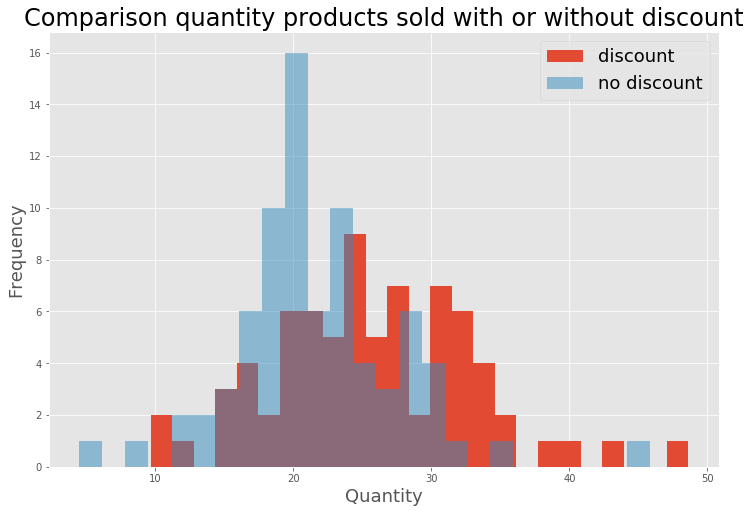

In [10]:
plt.style.use('ggplot')
plt.figure(figsize=(12,8))
plt.hist(disc, label = 'discount', bins = 25)
plt.hist(no_disc, label = 'no discount', alpha = .5, bins = 25)
plt.title('Comparison quantity products sold with or without discount', fontsize = 24)
plt.xlabel('Quantity', fontsize = 18)
plt.ylabel('Frequency', fontsize = 18)
plt.legend(fontsize = 18)
plt.show();

In [11]:
mean_diff_quant = np.mean(disc) - np.mean(no_disc)
mean_diff_quant

4.1010957260331935

After a first look at the histogram and at the mean difference between quantity ordered with or without discount applied, we are not yet able to get a valuable answer.
In the next step we gonna perform an  hipothesis test to check if there's statistical difference between those quantities, i.e we want to know if the mean difference found is due to random chance or not.

# Defining Null and Alternative Hipothesis

Considering that we wanna observe if the quantity sold discounted is greater than the quantity sold not discounted we'll perform a **_One Tail Test_**.

**H_null** = qt. discounted sold <= qt. not discounted sold

**H_alt** =  qt. discounted sold > qt. not discounted sold

Alpha level = 0.05

# Monte Carlo Simulations

Our data don't seem normally distributed, for this reason we'll use Monte Carlo Simulations that is a non-parametric test.

In [12]:
disc = df[df['Discount'] != 0]['Quantity']
no_disc = df[df['Discount'] == 0]['Quantity']

In [13]:
frames = [disc,no_disc]
all_data = pd.concat(frames)

In [14]:
type(all_data)

pandas.core.series.Series

In [15]:
df1 = pd.DataFrame({'all_data' : all_data})
df1.head()

,all_data
3,4
4,5
8,8
12,10
13,15


We have created a dataframe contaaining all the values from disc and no_disc

In [16]:
len(disc), len(no_disc), len(all_data)

(961, 1497, 2458)

Through the for loop below we gonna check if the sample mean difference for each sample is smaller than the mean difference of the distribution and in this case adding 1 to our counter.
Dividing the counter over sample size we get our p-value

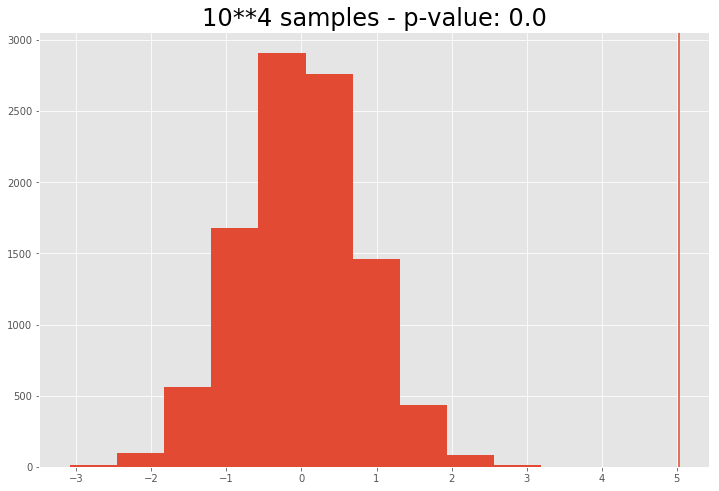

In [17]:
mean_diff_quant = np.mean(disc) - np.mean(no_disc)
sample_diff = []
counter = 0

for i in range(10**4):
    #Generate sample for discount
    sample_disc = df1.sample(n=len(disc), replace=False)
    #Generate sample no_discount
    sample_no_disc = df1.drop(sample_disc.index, axis = 0)
    sample_mean_diff = sample_disc['all_data'].mean() - sample_no_disc['all_data'].mean()
    sample_diff.append(sample_mean_diff)
    if sample_mean_diff < mean_diff_quant:
        counter += 1

plt.figure(figsize=(12,8))
plt.hist(sample_diff)
plt.axvline(mean_diff_quant)
plt.title(f'10**4 samples - p-value: {1 - counter/10**4}', fontsize = 24);

As we see the p-value is 0 so we reject the null hypothesis.
We can say that when the discount is applied on average the quantity sold is higher.

# Welch's Test

As a sanity check we gonna perform a Welch's Test that is commonly used in the industry for normal distributions having different mean.

In [18]:
stats.ttest_ind(disc, no_disc, equal_var= False)

Ttest_indResult(statistic=6.0192242098850555, pvalue=2.130356906716645e-09)

Again we reject the null hypothesis.

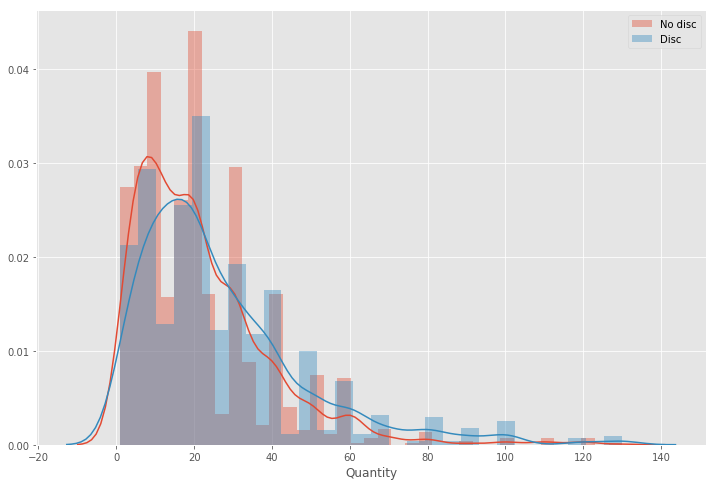

In [19]:
plt.figure(figsize=(12,8))
sns.distplot(no_disc, label = ('No disc'))
sns.distplot(disc, label= ('Disc'))
plt.legend();

# Effect Size

Cohen’s D is one of the most common ways to measure effect size.  As an effect size, Cohen's d is typically used to represent the magnitude of differences between two (or more) groups on a given variable, with larger values representing a greater differentiation between the two groups on that variable. 

The basic formula to calculate Cohen’s $d$ is:


In [20]:
def Cohen_d(group1, group2):
    
    '''function to calculate Cohen's d coefficient'''

    diff = group1.mean() - group2.mean()
    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()
    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    d = diff / np.sqrt(pooled_var)
    return d

In [21]:
Cohen_d(disc, no_disc)

0.2600093359962642

As we can see from the d result obtained the effect size of 0.26 result being small.

# Check statistically significant difference with and without discount

# Defining Null and Alternative Hipotheses

Considering that we wanna observe if the quantity sold discounted is greater than the quantity sold not discounted we'll perform a **_One Tail Test_**.

**H_null** = qt. discounted sold <= qt. not discounted sold

**H_alt** =  qt. discounted sold > qt. not discounted sold


Alpha level = 0.05

Let's now check if different levels of discount are affecting the quantity sold and how

In [22]:
cur.execute("""SELECT ProductID, ProductName, UnitPrice, Quantity, Discount, Unitprice*quantity as Revenue
               FROM Product
               JOIN OrderDetail
               USING(UnitPrice)
               """)
df = pd.DataFrame(cur.fetchall()) #Take results and create dataframe
df.columns = [i[0] for i in cur.description]
df.head()

,ProductId,ProductName,UnitPrice,Quantity,Discount,Revenue
0,1,Chai,18.0,2,0.00,36.0
1,1,Chai,18.0,3,0.00,54.0
2,1,Chai,18.0,4,0.00,72.0
3,1,Chai,18.0,4,0.25,72.0
4,1,Chai,18.0,5,0.20,90.0


In [23]:
disc = df['Discount'].value_counts()
disc

0.00    1497
0.05     209
0.20     198
0.25     191
0.15     184
0.10     170
0.03       3
0.01       2
0.02       2
0.04       1
0.06       1
Name: Discount, dtype: int64

From our value_counts method comes out that few levels of discount are applied in very small quantities.
We decide so to take in consideration just the ones where the quantity level is decent for a comparison.

In [24]:
discounts = ([ 0.05, 0.1, 0.15, 0.2, 0.25])
no_discount = df[df['Discount']==0]['Quantity']

for x in discounts:
    
    discount = df[df['Discount']==x]['Quantity']
    st, p = stats.ttest_ind(discount, no_disc, equal_var= False)
    d = Cohen_d(discount , no_discount)
    print(f'p-value: {p},  discount: {x}, d: {d}' )

p-value: 0.00020242644293690925,  discount: 0.05, d: 0.34011892483332096
p-value: 0.059408472241625404,  discount: 0.1, d: 0.19226210772157185
p-value: 0.0006408369853993879,  discount: 0.15, d: 0.2932127973345307
p-value: 0.00046767005488145745,  discount: 0.2, d: 0.320693712836777
p-value: 0.0006551534111424134,  discount: 0.25, d: 0.28636073205553286


In [25]:
no_discount = df[df['Discount']==0]['Quantity']

for x in ([ 0.05, 0.1, 0.15, 0.2, 0.25]):
    
    discount = df[df['Discount']==x]['Quantity']
    st, p = stats.ttest_ind(discount, no_disc, equal_var= False)
    
    print(p)

0.00020242644293690925
0.059408472241625404
0.0006408369853993879
0.00046767005488145745
0.0006551534111424134


Results are all statistically significant except for the level 0.1.

This means that a discount of 10% on average doesn't have any impact on the quantity sold compared to not applying the discount.

We advice so, to use a 5% discount instead, d Cohen's for 5% discount results being the one with the highest effect size, moreover smaller leave us more profit but still does have an  higher impact on quantity sold compared to the 10%, or to apply an higher discount level to try to increase the quantity sold.

# Check statistically significant difference at different levels of discount

# Defining Null and Alternative Hipotheses

Considering that we wanna observe if the quantity sold discounted is greater than the quantity sold not discounted we'll perform a **_One Tail Test_**.

**H_null** = there is no statistically difference between discounts

**H_alt** =  there is statistically difference between discounts

Alpha level: 0.05

In [26]:

comb = itertools.combinations(discounts, 2)

for x in comb:
    
    contr = df[df['Discount']==x[0]]['Quantity']
    exp = df[df['Discount']==x[1]]['Quantity']
    
    st, p = stats.ttest_ind(contr, exp)
    d = Cohen_d(contr, exp)
    
    print(f'Discount: {str(x[0]*100)}% and {str(x[1]*100)}%, p-value: {p},  d: {d}')

Discount: 5.0% and 10.0%, p-value: 0.25576752160380695,  d: 0.11755232870607792
Discount: 5.0% and 15.0%, p-value: 0.639830153301604,  d: 0.04734246233079715
Discount: 5.0% and 20.0%, p-value: 0.8579967042318546,  d: 0.017755780684653263
Discount: 5.0% and 25.0%, p-value: 0.5948065678843857,  d: 0.05328623381918332
Discount: 10.0% and 15.0%, p-value: 0.45459677835538914,  d: -0.07963621479973648
Discount: 10.0% and 20.0%, p-value: 0.33029397253569537,  d: -0.10192625578530146
Discount: 10.0% and 25.0%, p-value: 0.4821959796432913,  d: -0.07417670900558068
Discount: 15.0% and 20.0%, p-value: 0.7755300970624632,  d: -0.029219731214445984
Discount: 15.0% and 25.0%, p-value: 0.951085415829296,  d: 0.006340926579426986
Discount: 20.0% and 25.0%, p-value: 0.7285682431691355,  d: 0.035221717744423016


Results, as we can see from the p-value, are all not statistically significant.

This means that we failed to reject the null hypothesis.

We advice the management build their strategies taking in consideration the presence or not of the discount instead of a comparison between different levels of discount.

# 2nd Question

### Is it December, considering the Christmas time period in it, the month with the highest revenue?

# Defining Null and Alternative Hipothesis

Considering that we wanna observe if the Revenue in December is greater than the other months we'll perform a **_One Tail Test_**.

**H_null** = Revenue for December <= Revenue other month

**H_alt** =  Revenue for December > Revenue other month

Alpha level = 0.05

We start querying our database to get info about Revenue and Date.

In [27]:
cur.execute("""SELECT ProductID, ProductName, UnitPrice, Quantity, Discount, Unitprice*quantity as Revenue
               FROM Product
               JOIN OrderDetail
               USING(UnitPrice)
               """)
df_rev = pd.DataFrame(cur.fetchall()) #Take results and create dataframe
df_rev.columns = [i[0] for i in cur.description]
df_rev.head()

,ProductId,ProductName,UnitPrice,Quantity,Discount,Revenue
0,1,Chai,18.0,2,0.00,36.0
1,1,Chai,18.0,3,0.00,54.0
2,1,Chai,18.0,4,0.00,72.0
3,1,Chai,18.0,4,0.25,72.0
4,1,Chai,18.0,5,0.20,90.0


Datetime is a usefull method that gives us several options to work with the date.

In this case we want to get the specific month and use it later combined with the Revenue.

In [28]:
cur.execute("""SELECT OrderDate
               FROM [order]
               """)
df = pd.DataFrame(cur.fetchall()) #Take results and create dataframe
df.columns = [i[0] for i in cur.description]
df.head()

,OrderDate
0,2012-07-04
1,2012-07-05
2,2012-07-08
3,2012-07-08
4,2012-07-09


In [29]:
df['OrderDate'] = pd.to_datetime(df['OrderDate'])
df['OrderDate']= df['OrderDate'].dt.month
df['OrderDate'].head()

0    7
1    7
2    7
3    7
4    7
Name: OrderDate, dtype: int64

In [30]:
result = pd.concat([df_rev, df['OrderDate']], axis=1)
result.head()

,ProductId,ProductName,UnitPrice,Quantity,Discount,Revenue,OrderDate
0,1,Chai,18.0,2,0.00,36.0,7.0
1,1,Chai,18.0,3,0.00,54.0,7.0
2,1,Chai,18.0,4,0.00,72.0,7.0
3,1,Chai,18.0,4,0.25,72.0,7.0
4,1,Chai,18.0,5,0.20,90.0,7.0


Let's plot our mean Revenue grouped by the month to get a first understand of the trend.

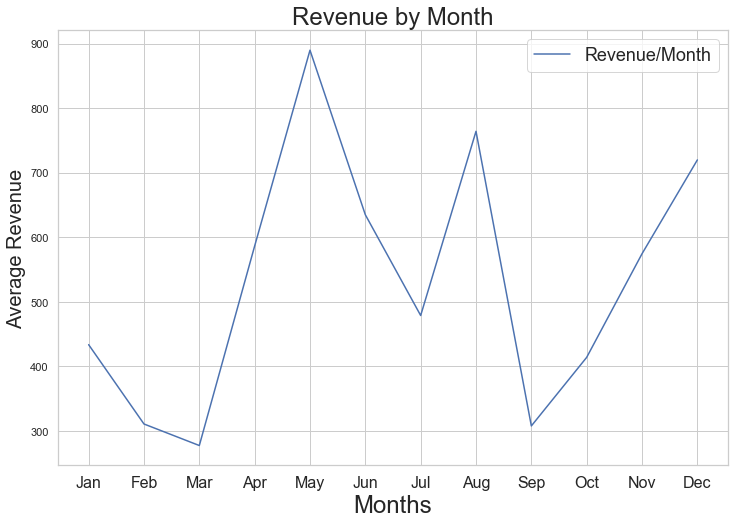

In [31]:
sns.set(style="whitegrid")
date_new_plot = result.groupby('OrderDate')['Revenue'].mean().plot(kind = 'line', figsize = (12,8), label = 'Revenue/Month')
date_new_plot.set_xlabel("Months", fontsize = 24)
date_new_plot.set_ylabel("Average Revenue", fontsize = 20)
plt.legend(fontsize = 18)
plt.title('Revenue by Month', fontsize = 24)
plt.xticks(range(1,13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize = 16);

That's interesting, because as we thought during December we've got an high Revenue peak due to the Christmas, but as we can see May results having the highest peak followed by August.

Let's further investigate using a Welch's Test. 

We assign to OrderDate 12 defining it as Revenue for the month of December.

In [32]:
rev_dec = result[result['OrderDate'] == 12]['Revenue']
rev_dec.head()

121    380.0
122    380.0
123    380.0
124    399.0
125    456.0
Name: Revenue, dtype: float64

In [33]:
months_no_dec = np.array([1,2,3,4,5,6,7,8,9,10,11])

month_revenue = pd.DataFrame(columns=['Month', 'P-value', 'Null Hypothesis','Cohens d'], index=None)

dec = result[result['OrderDate'] == 12]['Revenue']

for i in months_no_dec:
    no_dec = result[result['OrderDate'] == i]['Revenue']
    
    st, p = stats.ttest_ind(dec, no_dec)
    d = Cohen_d(no_dec, dec)
    
    month_revenue = month_revenue.append( { 'Month' :  i, 'P-value' : p, 'Null Hypothesis' : 'Reject' if p < 0.05 else 'Failed', 'Cohens d' : d } , ignore_index=True)    

month_revenue.sort_values('Cohens d', ascending=False)

,Month,P-value,Null Hypothesis,Cohens d
4,5,2.587298e-01,Failed,0.210380
7,8,7.235247e-01,Failed,0.061308
5,6,5.983209e-01,Failed,-0.113364
3,4,2.030295e-01,Failed,-0.190250
10,11,1.838974e-01,Failed,-0.229959
6,7,3.153316e-02,Reject,-0.381989
0,1,8.368373e-03,Reject,-0.413633
9,10,4.994054e-03,Reject,-0.479868
8,9,3.410447e-04,Reject,-0.629506
1,2,6.892920e-06,Reject,-0.730884


As we can see we failed to reject our hyphotheses for April, May, June, August and November.

This means that our Revenue is actually higher on these months compared to December.

Our advice is to focus our product strategies during these months, May furthermore gives us the highest effect size.

In fact could probably be more difficult trying to increase the overall Revenue during December, being the potential competition much higher and obstinate.

# 3rd Question

### Does discount amount have a statistically significant effect on the revenue of a product in an order? If so, at what level(s) of discount?

# Defining Null and Alternative Hipothesis

Considering that we wanna observe if the quantity sold discounted is greater than the quantity sold not discounted we'll perform a **_One Tail Test_**.

**H_null** = Revenue with discount <= Revenue without discount

**H_alt** =  Revenue with discount > Revenue without discount

Alpha level = 0.05

I decided to take the first question but to check this time the effect of different levels of discount on the Revenue.
The reason is that I'm more interested on the overall amount of income generated from a possible discount that on the amount.

In [34]:
cur.execute("""SELECT ProductID, ProductName, UnitPrice, Quantity, Discount, Unitprice*quantity as Revenue
               FROM Product
               JOIN OrderDetail
               USING(UnitPrice)
               """)
df = pd.DataFrame(cur.fetchall()) #Take results and create dataframe
df.columns = [i[0] for i in cur.description]
df.head()

,ProductId,ProductName,UnitPrice,Quantity,Discount,Revenue
0,1,Chai,18.0,2,0.00,36.0
1,1,Chai,18.0,3,0.00,54.0
2,1,Chai,18.0,4,0.00,72.0
3,1,Chai,18.0,4,0.25,72.0
4,1,Chai,18.0,5,0.20,90.0


In [35]:
rev_disc = df[df['Discount'] != 0].groupby('ProductId')['Revenue'].mean()
rev_disc.head()

ProductId
1    501.230769
2    461.588235
3    200.000000
4    679.250000
5    567.437500
Name: Revenue, dtype: float64

In [36]:
rev_no_disc = df[df['Discount'] == 0].groupby('ProductId')['Revenue'].mean()
rev_no_disc.head()

ProductId
1    328.500000
2    329.785714
3    260.000000
4    304.333333
5    588.566667
Name: Revenue, dtype: float64

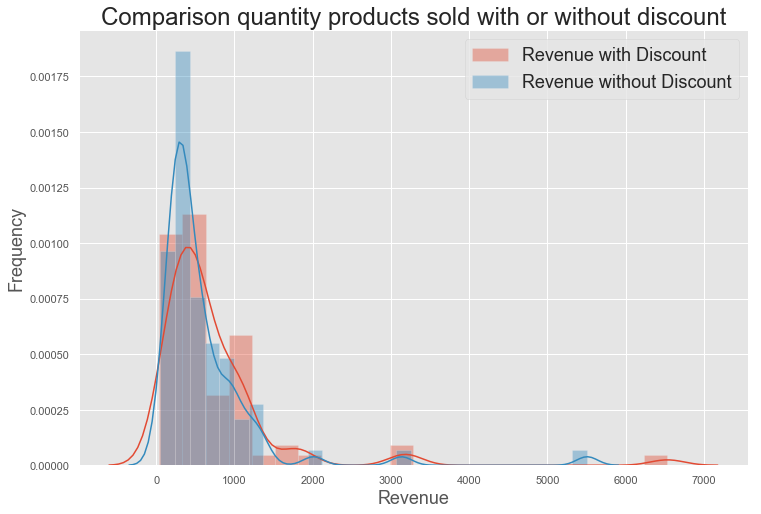

In [37]:
plt.style.use('ggplot')
plt.figure(figsize=(12,8))
sns.distplot(rev_disc, label = 'Revenue with Discount')
sns.distplot(rev_no_disc, label = 'Revenue without Discount')
plt.title('Comparison quantity products sold with or without discount', fontsize = 24)
plt.xlabel('Revenue', fontsize = 18)
plt.ylabel('Frequency', fontsize = 18)
plt.legend(fontsize = 18)
plt.show()

In [38]:
rev_disc = df[df['Discount'] != 0]['Revenue']

In [39]:
rev_no_disc = df[df['Discount'] == 0]['Revenue']

In [40]:
stats.ttest_ind(rev_disc, rev_no_disc, equal_var= False)

Ttest_indResult(statistic=2.522313457974173, pvalue=0.011737325507467939)

As we can see from the result of our test we reject our null hypothesis and accept the alternative.
Discount product increases the Revenue.

# Effect Size

In [41]:
Cohen_d(rev_disc, rev_no_disc)

0.10564117110264203

As we can see from the d result obtained the effect size of 0.1 result being almost null.

# Check statistically significant difference with and without discount

# Defining Null and Alternative Hipotheses

Considering that we wanna observe if the quantity sold discounted is greater than the quantity sold not discounted we'll perform a **_One Tail Test_**.

**H_null** = Revenue with discount <= Revenue without discount

**H_alt** =  Revenue with discount > Revenue without discount

Alpha level = 0.05

Let's now check if different levels of discount are affecting the Revenue and how.

In [42]:
disc = df['Discount'].value_counts()
disc

0.00    1497
0.05     209
0.20     198
0.25     191
0.15     184
0.10     170
0.03       3
0.01       2
0.02       2
0.04       1
0.06       1
Name: Discount, dtype: int64

From our value_counts method comes out that few levels of discount are applied in very small quantities.
We decide so to take in consideration just the ones where the quantity level is decent for a comparison.

In [43]:
rev_no_disc = df[df['Discount']==0]['Revenue']

for x in ([ 0.05, 0.1, 0.15, 0.2, 0.25]):
    
    rev_disc = df[df['Discount']==x]['Revenue']
    st, p = stats.ttest_ind(rev_disc, rev_no_disc, equal_var= False)
    d = Cohen_d(rev_disc, rev_no_disc)
    print(f'p-value: {p},  discount: {x}, d: {d}' )

p-value: 0.026181170332631516,  discount: 0.05, d: 0.23499878203686098
p-value: 0.8749201423474035,  discount: 0.1, d: 0.009876965503309925
p-value: 0.24687332455838845,  discount: 0.15, d: 0.06549314253400994
p-value: 0.8130787365105839,  discount: 0.2, d: 0.011927193415529289
p-value: 0.02698331079119023,  discount: 0.25, d: 0.20174050632526866


Results are not statistically significant for the levels 0.1, 0.15 and 0.2.

This means that a discount of 10%, 15% and 20% on average doesn't have any impact on the Revenue for the product sold compared to not applying the discount.

We advice so, to use a 5% discount instead, that being smaller leave us more profit but still does have an  higher impact on Revenue, considering also the highest effect  size, compared to the 10%, 15% an 20% or to apply a 25% discount level to try to increase the total Revenue.

# Check statistically significant difference at different levels of discount

# Defining Null and Alternative Hipotheses

Considering that we wanna observe if the quantity sold discounted is greater than the quantity sold not discounted we'll perform a **_One Tail Test_**.

**H_null** = there is no statistically difference in Revenue for different discounts

**H_alt** =  there is statistically difference in Revenue for different discounts

Alpha level: 0.05

In [44]:
comb = itertools.combinations(discounts, 2)

for x in comb:
    
    contr = df[df['Discount']==x[0]]['Revenue']
    exp = df[df['Discount']==x[1]]['Revenue']
    
    st, p = stats.ttest_ind(contr, exp)
    d = Cohen_d(contr, exp)
    
    print(f'Discount: {str(x[0]*100)}% and {str(x[1]*100)}%, p-value: {p},  d: {d}')

Discount: 5.0% and 10.0%, p-value: 0.06517254303870261,  d: 0.1910483574305983
Discount: 5.0% and 15.0%, p-value: 0.12964825499108507,  d: 0.15354387633774313
Discount: 5.0% and 20.0%, p-value: 0.04420492874996164,  d: 0.2001832293108724
Discount: 5.0% and 25.0%, p-value: 0.733129689733457,  d: 0.034156048076922844
Discount: 10.0% and 15.0%, p-value: 0.4625311427899734,  d: -0.07824198801905095
Discount: 10.0% and 20.0%, p-value: 0.9785841119668095,  d: -0.0028086098847953174
Discount: 10.0% and 25.0%, p-value: 0.06860009157186063,  d: -0.19260786884600922
Discount: 15.0% and 20.0%, p-value: 0.40933360021740195,  d: 0.08457743974149963
Discount: 15.0% and 25.0%, p-value: 0.1613009261420234,  d: -0.14498176212939648
Discount: 20.0% and 25.0%, p-value: 0.04458377029585462,  d: -0.20436750404800139


We reject our null hypothesis for 5% and 20% discounts and 20% and 25% discounts.

This means that there's statistical significant difference in terms of Revenue taking in consideration these 2 different levels of discount.

Our advice is to focus our attention on 5% and 20% , the d Cohen's effect size is significantly higher and the possibly strategies leave us with a higher profit being on comparison 25% discount higher than these 2.

# 4th Question

### There is a statistically significant difference on shipping time between different shipper companies?

Let's check if the shipping companies are all equally efficient or not.

# Defining Null and Alternative Hipothesis

Considering that we wanna observe if the time for the delivery sold discounted is greater than the quantity sold not discounted we'll perform a **_One Tail Test_**.

**H_null** = there is no statistically difference beetwen different companies in terms of shipping time

**H_alt** =  there is statistically difference beetwen different companies in terms of shipping time

Alpha level: 0.05

In [45]:
cur.execute("""SELECT *
               FROM shipper
               """)
df = pd.DataFrame(cur.fetchall()) #Take results and create dataframe
df.columns = [i[0] for i in cur.description]
df.head()

,Id,CompanyName,Phone
0,1,Speedy Express,(503) 555-9831
1,2,United Package,(503) 555-3199
2,3,Federal Shipping,(503) 555-9931


In [46]:
dates1 = pd.read_sql_query('''
                            SELECT companyname, [order].Id, Quantity, UnitPrice, OrderDate, shippedDate, 
                            ShipCountry, Quantity*UnitPrice as Revenue
                            
                            FROM [order]
                            JOIN orderdetail
                            
                            ON [Order].Id = orderdetail.orderid
                            JOIN shipper
                            ON shipper.id = [order].shipvia
                            
                        
                            ''', conn)

In [47]:
dates1.head()

,CompanyName,Id,Quantity,UnitPrice,OrderDate,ShippedDate,ShipCountry,Revenue
0,Federal Shipping,10248,12,14.0,2012-07-04,2012-07-16,France,168.0
1,Federal Shipping,10248,10,9.8,2012-07-04,2012-07-16,France,98.0
2,Federal Shipping,10248,5,34.8,2012-07-04,2012-07-16,France,174.0
3,Speedy Express,10249,9,18.6,2012-07-05,2012-07-10,Germany,167.4
4,Speedy Express,10249,40,42.4,2012-07-05,2012-07-10,Germany,1696.0


In [48]:
dates1.isnull().sum()

CompanyName     0
Id              0
Quantity        0
UnitPrice       0
OrderDate       0
ShippedDate    73
ShipCountry     0
Revenue         0
dtype: int64

In [49]:
dates1.dropna(subset = ['ShippedDate'], inplace=True)
dates1.isnull().sum()

CompanyName    0
Id             0
Quantity       0
UnitPrice      0
OrderDate      0
ShippedDate    0
ShipCountry    0
Revenue        0
dtype: int64

Through the code below we are going to measure the difference between 2 dates so that we can check the time that took to a company to complete a spedition.

In [50]:
from datetime import datetime
date_format = "%Y-%m-%d"
a = []
b = []
for x in dates1['OrderDate']:
    a.append(datetime.strptime(x, date_format))
for y in dates1['ShippedDate']:
    b.append(datetime.strptime(y, date_format))

In [51]:
a_arr = np.array(a)
b_arr = np.array(b)

In [52]:
time_ship = abs(a_arr - b_arr)
type(time_ship)

numpy.ndarray

In [53]:
x = pd.to_timedelta(time_ship)
time_df = pd.DataFrame(x.days)
time_df.head()

,0
0,12
1,12
2,12
3,5
4,5


In [54]:
time_df.columns= ['DaysDelivery']
result = pd.concat([dates1, time_df], axis=1)
result.isnull().sum()

CompanyName     15
Id              15
Quantity        15
UnitPrice       15
OrderDate       15
ShippedDate     15
ShipCountry     15
Revenue         15
DaysDelivery    15
dtype: int64

In [55]:
result.dropna(subset=['CompanyName'], inplace=True)
result.dropna(subset=['DaysDelivery'], inplace=True)
result.isnull().sum()

CompanyName     0
Id              0
Quantity        0
UnitPrice       0
OrderDate       0
ShippedDate     0
ShipCountry     0
Revenue         0
DaysDelivery    0
dtype: int64

In [56]:
result.head()

,CompanyName,Id,Quantity,UnitPrice,OrderDate,ShippedDate,ShipCountry,Revenue,DaysDelivery
0,Federal Shipping,10248.0,12.0,14.0,2012-07-04,2012-07-16,France,168.0,12.0
1,Federal Shipping,10248.0,10.0,9.8,2012-07-04,2012-07-16,France,98.0,12.0
2,Federal Shipping,10248.0,5.0,34.8,2012-07-04,2012-07-16,France,174.0,12.0
3,Speedy Express,10249.0,9.0,18.6,2012-07-05,2012-07-10,Germany,167.4,5.0
4,Speedy Express,10249.0,40.0,42.4,2012-07-05,2012-07-10,Germany,1696.0,5.0


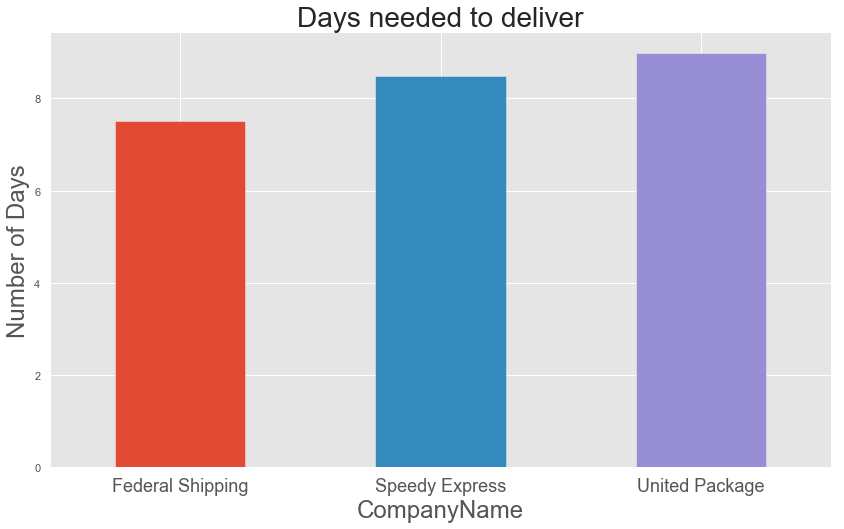

In [57]:
result.groupby('CompanyName')['DaysDelivery'].mean().plot(kind = 'bar', figsize = (14,8), rot = 0)
plt.title('Days needed to deliver', fontsize = 28)
plt.ylabel('Number of Days', fontsize = 24)
plt.xlabel('CompanyName', fontsize = 24)
plt.xticks(fontsize = 18);

After a first look at the graphic we can say that Federal Shipping seems to take on average less days to complete a delivery.

Let's check this through a multicomparison test: Tukey.

In [58]:
federal_ship = result[result['CompanyName'] == 'Federal Shipping']['DaysDelivery']
speedy_ship = result[result['CompanyName'] == 'Speedy Express']['DaysDelivery']
united_ship = result[result['CompanyName'] == 'United Package']['DaysDelivery']

In [59]:
v = np.concatenate([federal_ship, speedy_ship, united_ship])
len(v)

2067

In [60]:
labels = ['federal_ship'] * len(federal_ship) + ['speedy_ship'] * len(speedy_ship) + ['united_ship'] * len(united_ship) 
len(labels)

2067

In [61]:
print(pairwise_tukeyhsd(v, labels, 0.05))

  Multiple Comparison of Means - Tukey HSD,FWER=0.05  
   group1       group2   meandiff lower  upper  reject
------------------------------------------------------
federal_ship speedy_ship  0.9739  0.0934 1.8544  True 
federal_ship united_ship  1.4712  0.639  2.3033  True 
speedy_ship  united_ship  0.4973  -0.336 1.3305 False 
------------------------------------------------------


The test shows clearly that Federal Shipping is more efficient .

We advice the management to understand why the others companies are taking longer and in case to ask for a discount or to switch all the orders to the Federal shipper.

In [62]:
federal_ship = dates1[dates1['CompanyName'] == 'Federal Shipping']['Revenue']
speedy_ship = dates1[dates1['CompanyName'] == 'Speedy Express']['Revenue']
united_ship = dates1[dates1['CompanyName'] == 'United Package']['Revenue']

In [63]:
v = np.concatenate([federal_ship, speedy_ship, united_ship])
len(v)

2082

In [64]:
labels = ['federal_ship'] * len(federal_ship) + ['speedy_ship'] * len(speedy_ship) + ['united_ship'] * len(united_ship) 
len(labels)

2082

In [65]:
print(pairwise_tukeyhsd(v, labels, 0.05))

     Multiple Comparison of Means - Tukey HSD,FWER=0.05    
   group1       group2   meandiff   lower    upper   reject
-----------------------------------------------------------
federal_ship speedy_ship -49.3423 -186.9615  88.277  False 
federal_ship united_ship 50.5271   -79.4336 180.4878 False 
speedy_ship  united_ship 99.8694   -29.9765 229.7152 False 
-----------------------------------------------------------


# 5th Question

### There's statistically significant difference between Revenue for different countries?

# Defining Null and Alternative Hipothesis

Considering that we wanna observe if Revenue of a country is greater than the Revenue of another country we'll perform a **_One Tail Test_**.

**H_null** = there is no statistically difference beetwen different Countries in terms of Revenue

**H_alt** =  there is statistically difference beetwen different Countries in terms of Revenue

Alpha level: 0.05

In [66]:
dates1 = pd.read_sql_query('''
                            SELECT [order].Id, Quantity, UnitPrice, ShipCountry, Quantity*UnitPrice as Revenue
                            
                            FROM [order]
                            JOIN orderdetail
                            
                            ON [Order].Id = orderdetail.orderid
                            JOIN shipper
                            ON shipper.id = [order].shipvia
                            
                        
                            ''', conn)

In [67]:
dates1.head()

,Id,Quantity,UnitPrice,ShipCountry,Revenue
0,10248,12,14.0,France,168.0
1,10248,10,9.8,France,98.0
2,10248,5,34.8,France,174.0
3,10249,9,18.6,Germany,167.4
4,10249,40,42.4,Germany,1696.0


In [68]:
df = dates1[(dates1['Quantity'] >= 50) & (dates1['Revenue'] >= 1500)].groupby('ShipCountry')['Revenue'].mean()
df

ShipCountry
Austria        3565.855556
Belgium        2750.000000
Brazil         5541.000000
Canada         2116.000000
Denmark        6638.000000
France         2312.500000
Germany        3583.290833
Ireland        5952.025000
Sweden         3135.900000
Switzerland    1964.000000
UK             2431.500000
USA            2715.600000
Venezuela      2040.500000
Name: Revenue, dtype: float64

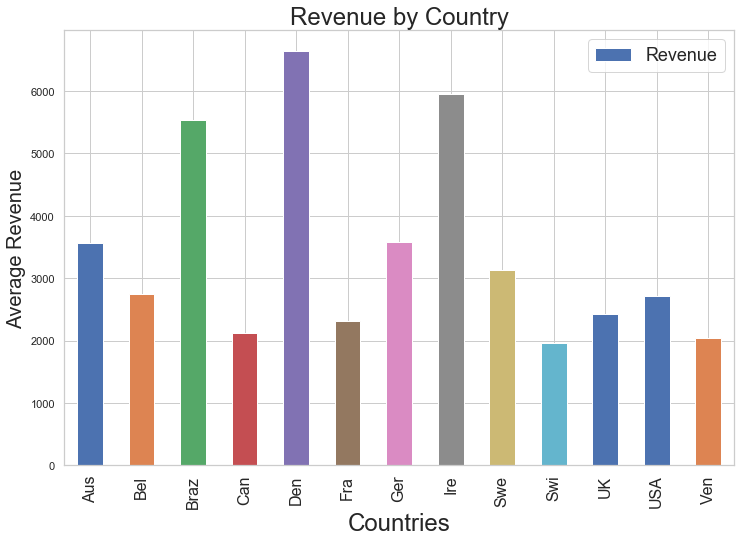

In [69]:
sns.set(style="whitegrid")
new_plot = df.plot.bar(figsize = (12,8))
new_plot.set_xlabel("Countries", fontsize = 24)
new_plot.set_ylabel("Average Revenue", fontsize = 20)
plt.legend(fontsize = 18)
plt.title('Revenue by Country', fontsize = 24)
plt.xticks(range(0,13), ['Aus', 'Bel', 'Braz', 'Can', 'Den', 'Fra', 'Ger', 'Ire', 'Swe', 'Swi', 'UK', 'USA', 'Ven'], fontsize = 16);

As we can see from above, the highest quantity of products has been sold in the USA.
We want so check if the revenue matches this situation or if our company should be investing more in other countries.

In [70]:
df = dates1[(dates1['Quantity'] >= 50) & (dates1['Revenue'] >= 1500)]
df.head()

,Id,Quantity,UnitPrice,ShipCountry,Revenue
53,10267,70,44.0,Germany,3080.0
183,10316,70,39.4,USA,2758.0
200,10324,80,35.1,USA,2808.0
244,10339,70,31.2,Canada,2184.0
259,10344,70,32.0,USA,2240.0


In [71]:
dict_country = {}
for x in df['ShipCountry'].unique():
    dict_country[x] = df[df['ShipCountry'] == x]['Revenue']

In [72]:
list_country = []
for x in dict_country:
    a = [str(x)] * len(dict_country[x])
    list_country.append(a)

In [73]:
labels = np.concatenate(list_country)

In [74]:
country_lis = []
for x in dict_country:
    country_lis.append(dict_country[x].values)
    
country_lis
v = np.concatenate(country_lis)

In [75]:
len(labels), len(v)

(89, 89)

In [76]:
print(pairwise_tukeyhsd(v, labels, 0.05))

       Multiple Comparison of Means - Tukey HSD,FWER=0.05       
   group1      group2    meandiff     lower      upper    reject
----------------------------------------------------------------
  Austria     Belgium   -815.8556  -10082.5251  8450.814  False 
  Austria      Brazil   1975.1444   -3010.5794 6960.8683  False 
  Austria      Canada   -1449.8556  -5467.4663 2567.7552  False 
  Austria     Denmark   3072.1444   -3650.6042 9794.8931  False 
  Austria      France   -1253.3556  -7976.1042 5469.3931  False 
  Austria     Germany    17.4353    -3343.9391 3378.8096  False 
  Austria     Ireland   2386.1694   -2599.5544 7371.8933  False 
  Austria      Sweden   -429.9556   -4989.5455 4129.6344  False 
  Austria   Switzerland -1601.8556  -8324.6042 5120.8931  False 
  Austria        UK     -1134.3556  -6120.0794 3851.3683  False 
  Austria       USA     -850.2556   -3662.5831  1962.072  False 
  Austria    Venezuela  -1525.3556  -6511.0794 3460.3683  False 
  Belgium      Brazil    

We reject the Null Hypothesis for all the countries compared in terms of Revenue.

The Profit is the same in proportion no matter which Country we take in consideration.

For this reason we advice the management to keep investing also on those contries where the revenue is not as high as the others, in fact from the test results that on average the Revenue obtained is the same.

# Category

### There is statistically significant difference between different categories?

# Defining Null and Alternative Hipothesis

Considering that we wanna observe if Revenue of a category is greater than the Revenue of another category we'll perform a **_One Tail Test_**.

**H_null** = there is no statistically difference beetwen different categories in terms of Revenue

**H_alt** =  there is statistically difference beetwen different categories in terms of Revenue

Alpha level: 0.05

We want to check if some categories are more valuable than others in terms of Revenue.

In [77]:
cat = pd.read_sql_query('''
                            SELECT CategoryId, CategoryName, Description,
                            Category.Id, Quantity, UnitPrice, Quantity*UnitPrice as Revenue
                            
                            FROM Category
                            JOIN Product
                          
                            USING(Id)
                            JOIN OrderDetail
                            USING(UnitPrice)
                            
                        
                            ''', conn)

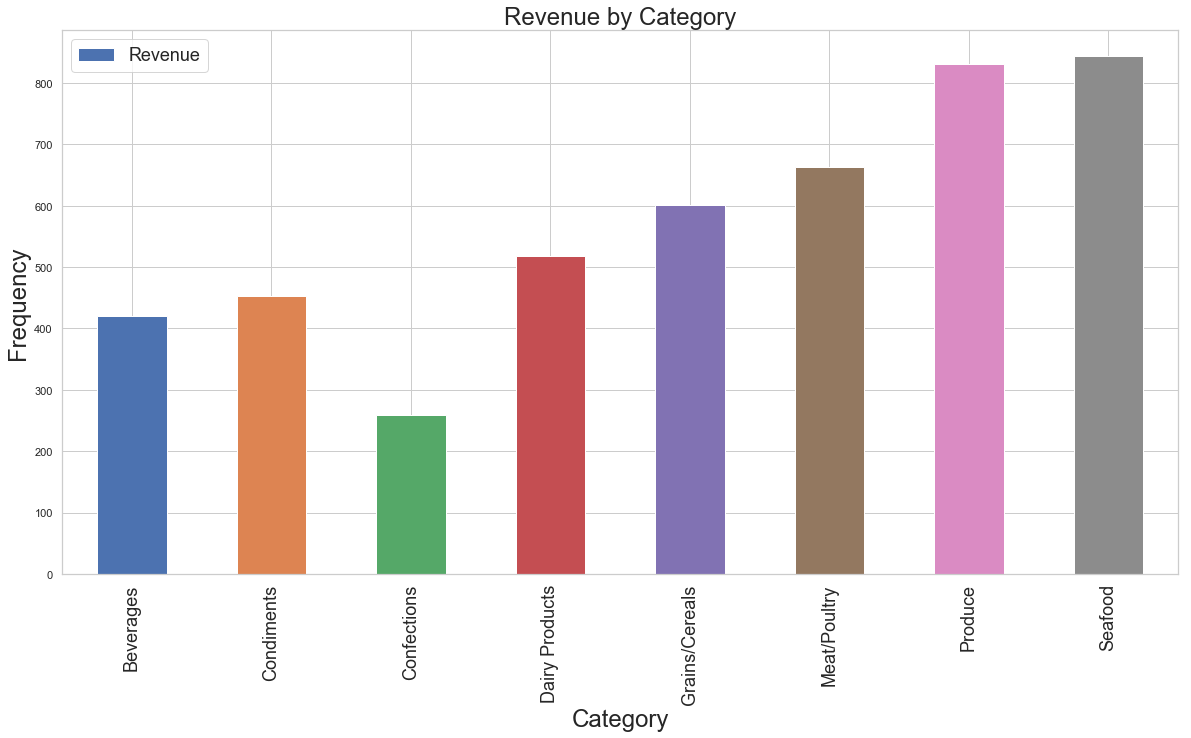

In [78]:
cat.groupby('CategoryName')['Revenue'].mean().plot(kind = 'bar', figsize = (20,10))
plt.legend(fontsize = 18)
plt.title('Revenue by Category', fontsize = 24)
plt.xticks(fontsize = 18)
plt.xlabel('Category', fontsize = 24)
plt.ylabel('Frequency', fontsize = 24);

In [79]:
dict_cat = {}
for x in cat['CategoryName'].unique():
    print(cat[cat['CategoryName'] == x]['Revenue'])
    dict_cat[x] = cat[cat['CategoryName'] == x]['Revenue']
    

0        36.0
1        36.0
2        36.0
3        36.0
4        54.0
5        54.0
6        54.0
7        54.0
8        72.0
9        72.0
10       72.0
11       72.0
12       72.0
13       90.0
14       90.0
15       90.0
16      108.0
17      108.0
18      108.0
19      108.0
20      144.0
21      144.0
22      144.0
23      144.0
24      144.0
25      162.0
26      180.0
27      180.0
28      180.0
29      180.0
        ...  
72      540.0
73      540.0
74      540.0
75      540.0
76      540.0
77      540.0
78      540.0
79      630.0
80      630.0
81      630.0
82      630.0
83      720.0
84      720.0
85      720.0
86      720.0
87      792.0
88      810.0
89      810.0
90      900.0
91      900.0
92      900.0
93      900.0
94     1080.0
95     1080.0
96     1080.0
97     1440.0
98     1440.0
99     1440.0
100    1620.0
101    2340.0
Name: Revenue, Length: 102, dtype: float64
102      57.0
103      95.0
104      95.0
105      95.0
106     114.0
107     114.0
108     152.0
109  

In [80]:
list_category = []
for x in dict_cat:
    a = [str(x)] * len(dict_cat[x])
    list_category.append(a)

In [81]:
labels = np.concatenate(list_category)

In [82]:
cat_lis = []
for x in dict_cat:
    cat_lis.append(dict_cat[x].values)
    
cat_lis
v = np.concatenate(cat_lis)

In [83]:
len(labels), len(v)

(292, 292)

In [84]:
print(pairwise_tukeyhsd(v, labels, 0.05))

        Multiple Comparison of Means - Tukey HSD,FWER=0.05       
    group1         group2      meandiff   lower    upper   reject
-----------------------------------------------------------------
  Beverages      Condiments    32.4206  -167.8972 232.7385 False 
  Beverages     Confections   -160.7755 -343.6215 22.0706  False 
  Beverages    Dairy Products  98.2185  -238.9575 435.3945 False 
  Beverages    Grains/Cereals  181.0054  -315.962 677.9728 False 
  Beverages     Meat/Poultry   242.1471 -149.8661 634.1603 False 
  Beverages       Produce      410.0471  146.0351 674.059   True 
  Beverages       Seafood      423.2834  47.8486  798.7182  True 
  Condiments    Confections   -193.1961 -407.9473  21.555  False 
  Condiments   Dairy Products  65.7978   -289.692 421.2877 False 
  Condiments   Grains/Cereals  148.5847 -360.9857 658.1552 False 
  Condiments    Meat/Poultry   209.7264 -198.1458 617.5986 False 
  Condiments      Produce      377.6264  90.5939  664.6589  True 
  Condimen

From our test results that there's a significant difference between categories.

Comes out that the categories with the highest Revenue are Seafood, Produce and Meat/Poultry.

In particular we raccomand to focus our production on Produce.

Being the description of this category "Dried fruit and bean curd" we know that are easy to conserve and ship compared to Seafood and Meat/Poultry.
